# Project: Quantitative Analysis with S&P500 Stock Selection for Portfolio Construction

## Introduction
1. What is my objective?
    - Test my difference portfolio strategy.
    - Focus stocks in S&P500 which are high-yielding stocks trusted by the market.

2. What business get?
    - Help make investment decisions based on principles, not emotions or rumors.

3. Understand the dataset
    - Source
        - Stock price data collected using yfinance from Yahoo Finance.
        - Dataset includes daily adjusted close prices of S&P 500 component stocks.
    - Time Period
        - Data covers January 1, 2015 – December 31, 2024 (10 years).
        - There contain shocks, high volatilities, current in good and bad economic times.
        - Suitable for evaluating stocks in all aspects
    - Assets
        - Focus on companies listed in the S&P 500 Index (USA large-cap equity market benchmark).
        - Includes only stocks with full historical data over the selected period.

## Plans
1. Dowload data in 10 years period (around 1 economic cycle, 2015-2024).

2. Calculate Sharpe-Ratio, Beta in CAPM, Z-score for strategy

3. Create 6 strategy using 10 stocks for decided.

4. Compare both portfolio strategy using 
    - Return (CAGM), Volatility, Maximum Drawdown
    - Sharpe Ratio, Sortino Ratio, Calmar Ratio
    - VaR + Monte-Carlo

5. Conclusion

## 0. Setup basics library & data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimization
from scipy.stats import zscore

In [2]:
url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
df = pd.read_csv(url)
tickers = df["Symbol"].str.replace(".", "-", regex=False).tolist()

## 1. Dowload Data

### 1.1 Dowload S&P500 stocks data
- Turn close price daily data to monthly.
- Normalize it using percentage change.
- Drop NULL.
- Drop out stocks which not has full historical data over the selected period.

In [3]:
start = "2014-12-01"
end = "2024-12-31"
expected_months = 12*10 + 1

ME_price = {}

for ticker in tickers:
    try:
        load = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
        data = load["Close"].resample("ME").last().ffill()

        if len(data) == expected_months:
            ME_price[ticker] = data
            
    except Exception as e:
        print(f"{ticker} error: {e}")

### 1.2 Format and Check data

In [4]:
cl_price = pd.concat(ME_price.values(), axis=1)
cl_price.columns = ME_price.keys()

In [5]:
cl_price.isnull().sum().max()

np.int64(0)

In [6]:
cl_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2014-12-31 to 2024-12-31
Freq: ME
Columns: 467 entries, MMM to ZTS
dtypes: float64(467)
memory usage: 442.4 KB


In [7]:
cl_price.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,96.674500,23.768890,36.678383,42.105335,74.645462,72.699997,2.67,9.287025,23.678877,37.452259,...,24.314837,100.860001,81.610001,127.874580,25.593815,33.234421,42.711456,77.410004,101.194794,39.631195
2015-01-31,95.486069,25.032967,36.659584,39.121830,70.232407,70.129997,2.57,8.308434,22.124575,34.636936,...,23.730501,97.461266,79.459999,127.178375,26.740986,29.768688,42.617912,83.459999,100.017067,39.428917
2015-02-28,99.839073,26.641418,38.797253,39.219070,75.247208,79.099998,3.11,8.818362,24.281654,38.708618,...,26.533152,107.409981,85.500000,123.693230,25.137802,31.289343,47.824272,91.050003,107.413528,42.529335
2015-03-31,97.648758,27.753061,37.945461,37.948505,78.306259,73.940002,2.68,8.736773,24.968174,38.197224,...,27.708776,109.149536,84.410004,109.266685,25.035471,30.693359,46.415073,90.720001,105.046623,42.713890
2015-04-30,92.581322,27.087044,38.213688,42.263447,78.265228,76.059998,2.26,9.008735,24.589811,38.031754,...,28.037394,110.168991,91.209999,96.411293,24.388193,32.446259,50.950764,92.080002,98.181770,41.061916


## 2. Choose 10 stocks for portfolio

### 2.1 Sharpe-Ratio
- Turn risk-free rate using 10-Year Treasury Yield (2015-2024) ≈ 2.3% annually to monthly
- For strategy 2
    - Choose stocks with Sharpe Ratio > 1.0

In [8]:
rf_annual = 0.023
rf_monthly = (1 + rf_annual) ** (1/12) - 1

In [9]:
def CAGR(DF):
    df = DF.copy().pct_change().dropna()
    df = (1 + df).cumprod()
    n = len(df) / 12
    return (df.iloc[-1])**(1/n) - 1

def volatility(DF):
    df = DF.copy().pct_change().dropna()
    return df.std() * np.sqrt(12)

def sharpe(series):
    return (CAGR(series) - rf_monthly) / volatility(series)

In [10]:
results = pd.DataFrame(index=cl_price.columns)
results["CAGR"] = cl_price.apply(CAGR)
results["Volatility"] = cl_price.apply(volatility)
results["Sharpe"] = cl_price.apply(sharpe)

selected_stocks = results[results["Sharpe"] > 1.0]

print("Sharpe Ratio > 1.0 with CAGR")
len(selected_stocks)

Sharpe Ratio > 1.0 with CAGR


19

### 2.2 beta
- For strategy 1
    - Choose stocks with Sharpe Ratio > 1.0
    - And beta is acceptable

In [11]:
market_data = yf.download("^GSPC", start=start, end=end, progress=False, auto_adjust=True)
market_close = market_data["Close"].resample("ME").last().ffill()
market_returns = market_close.pct_change().dropna()

In [12]:
market_returns.isnull().sum().max()

np.int64(0)

In [13]:
def calc_beta(stock_returns, market_returns):
    cov_matrix = np.cov(stock_returns, market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    return beta

In [14]:
beta_list = []

for ticker in selected_stocks.index:
    stock_returns = cl_price[ticker].pct_change().dropna()

    aligned = pd.concat([stock_returns, market_returns], axis=1).dropna()
    beta = calc_beta(aligned.iloc[:, 0], aligned.iloc[:, 1])
    beta_list.append(beta)

In [15]:
selected_stocks = results[results["Sharpe"] > 1.0].copy()
selected_stocks["Beta"] = beta_list

print("Stocks with Sharpe Ratio > 1.0 and corresponding Beta:")
print(selected_stocks.info())

Stocks with Sharpe Ratio > 1.0 and corresponding Beta:
<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, ANET to TMUS
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CAGR        19 non-null     float64
 1   Volatility  19 non-null     float64
 2   Sharpe      19 non-null     float64
 3   Beta        19 non-null     float64
dtypes: float64(4)
memory usage: 760.0+ bytes
None


### 2.3 z-score
- For strategy 3
    - Choose stocks with zscore is top

In [16]:
zdf = results.copy()

zdf["z_sharpe"] = zscore(zdf["Sharpe"].fillna(0))
zdf["z_cagr"] = zscore(zdf["CAGR"].fillna(0))
zdf["z_vol"] = zscore(zdf["Volatility"].fillna(0))

zdf["CompositeScore"] = zdf["z_sharpe"] + zdf["z_cagr"] - zdf["z_vol"]
zdf.sort_values("CompositeScore", ascending=False).head(10)

,CAGR,Volatility,Sharpe,z_sharpe,z_cagr,z_vol,CompositeScore
NVDA,0.760323,0.466290,1.626511,3.916401,7.013487,1.896368,9.033521
AVGO,0.408486,0.321099,1.266245,2.733538,3.170259,0.356165,5.547632
FICO,0.394960,0.309748,1.268977,2.742507,3.022502,0.235755,5.529254
PGR,0.275573,0.206388,1.326030,2.929830,1.718403,-0.860696,5.508929
CDNS,0.318784,0.257972,1.228379,2.609213,2.190416,-0.313484,5.113114
MSFT,0.266891,0.218811,1.211063,2.552359,1.623564,-0.728909,4.904832
RSG,0.196251,0.159697,1.217017,2.571908,0.851946,-1.355990,4.779844
LLY,0.297961,0.254626,1.162741,2.393704,1.962953,-0.348982,4.705639
MSCI,0.302890,0.263355,1.142920,2.328624,2.016797,-0.256386,4.601807
TMUS,0.236397,0.207748,1.128769,2.282162,1.290467,-0.846263,4.418891


### 2.4 Prepare data for strategy
- Strategy 1
    - Choose stocks which Sharpe-Ratio > 1.0
    - 10% or 1 stocks: (beta > 1.2) with most return --> argressive stocks
    - 20% or 2 stocks: (1.2 > beta > 1.0) with most return --> growth stocks
    - 30% or 3 stocks: (1.0 > beta > 0.8) with most return --> balance stocks
    - 40% or 4 stocks: (0.8 > beta) with most return --> defensive stocks

-  Strategy 2
    - Top 10 stocks with most Sharpe-Ratio

- Strategy 3
    - Top 10 stocks with most z-score

- Strategy 4
    - Rebalancing Portfolio monthly using top 10 stocks with most return in S&P500
    - We will show this code on section 3.

- Strategy 5
    - Rebalancing Portfolio quarterly using top 10 stocks with most return in S&P500
    - We will show this code on section 3.

- Strategy 6
    - Rebalancing Portfolio annually using top 10 stocks with most return in S&P500
    - We will show this code on section 3.

In [17]:
## check
print((selected_stocks["Beta"] > 1.2).sum())
print(((1.2 > selected_stocks["Beta"]) & (selected_stocks["Beta"] > 1.0)).sum())
print(((1.0 > selected_stocks["Beta"]) & (selected_stocks["Beta"] > 0.8)).sum())
print((0.8 > selected_stocks["Beta"]).sum())

4
6
4
5


In [18]:
## Strategy 1
group1 = selected_stocks[selected_stocks["Beta"] > 1.2].nlargest(1, "CAGR")
group2 = selected_stocks[(1.2 > selected_stocks["Beta"]) & (selected_stocks["Beta"] > 1.0)].nlargest(2, "CAGR")
group3 = selected_stocks[(1.0 > selected_stocks["Beta"]) & (selected_stocks["Beta"] > 0.8)].nlargest(3, "CAGR")
group4 = selected_stocks[0.8 > selected_stocks["Beta"]].nlargest(4, "CAGR")

strategy1 = pd.concat([group1, group2, group3, group4])
len(strategy1)

10

In [19]:
## Strategy 2
strategy2 = selected_stocks.nlargest(10, "Sharpe")
len(strategy2)

10

In [20]:
## Strategy 3
strategy3 = zdf.nlargest(10, "CompositeScore")

### 2.5 Optimize code (Maximize Sharpe-Ratio)
- Find best portfolio by Maxmimize Sharpe-Ratio

In [21]:
returns_series = cl_price.pct_change().dropna()

strategy1_series = returns_series[strategy1.index.tolist()]
strategy2_series = returns_series[strategy2.index.tolist()]
strategy3_series = returns_series[strategy3.index.tolist()]

In [22]:
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

## Gen Portfolios
def generate_portfolios(strategy):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    mean_returns = strategy.mean(axis=0)
    cov_matrix = strategy.cov()
    num_assets = strategy.shape[1]

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(num_assets)
        w /= np.sum(w)

        portfolio_weights.append(w)
        portfolio_means.append(np.dot(w, mean_returns))
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def statistics(weights, strategy):
    portfolio_return = np.sum(strategy.mean(axis=0) * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(strategy.cov(), weights)))
    sharpe = (portfolio_return - rf_monthly) / portfolio_volatility
    return np.array([portfolio_return, portfolio_volatility, sharpe])

def min_function_sharpe(weights, strategy):
    return -statistics(weights, strategy)[2]

def optimize_portfolio(weights, strategy):
    num_assets = strategy.shape[1]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    return optimization.minimize(fun=min_function_sharpe, x0=weights, args=(strategy,)
                                 , method='SLSQP', bounds=bounds, constraints=constraints)

def print_optimal_portfolio(optimum, strategy):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), strategy))

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

### 2.6 Backtesting code (Rebalance Portfolio)
- Using stocks weight equally, means if using 10 stocks in portfolio, each stock are 10% of portfolio.

In [24]:
def pflio_monthly(DF, m):
    """
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    """
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]

    for i in range(len(df)):
        if portfolio:
            monthly_ret.append(df[portfolio].iloc[i, :].mean(skipna=True))
        else:
            monthly_ret.append(0.0)

        portfolio = []
        new_picks = df.iloc[i, :].sort_values(ascending=False).head(m).index.tolist()
        portfolio = new_picks

        print(portfolio)

    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=["mon_ret"])
    return monthly_ret_df

In [27]:
def pflio_quarterly(DF, m):
    """
    DF = dataframe with monthly return info for all stocks
    m  = number of stocks in the portfolio
    """
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]

    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i, :].mean(skipna=True))
        else:
            monthly_ret.append(0.0)

        if (i + 1) % 3 == 0:
            start = max(0, i - 2)
            end = i

            portfolio = []
            q_ret_all = (1.0 + df.iloc[start:end+1]).prod(axis=0) - 1.0
            new_picks = q_ret_all.sort_values(ascending=False).head(m).index.tolist()
            portfolio = new_picks

            print(f"Month {i}: Portfolio = {portfolio}")

    monthly_ret = monthly_ret[:len(df)]
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=["mon_ret"])
    return monthly_ret_df

In [29]:
def pflio_annually(DF, m):
    """
    DF = dataframe with monthly return info for all stocks
    m  = number of stocks in the portfolio
    """
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]

    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i, :].mean(skipna=True))
        else:
            monthly_ret.append(0.0)

        if (i + 1) % 12 == 0:
            start = max(0, i - 11)
            end = i

            portfolio = []
            y_ret_all = (1.0 + df.iloc[start:end+1]).prod(axis=0) - 1.0
            new_picks = y_ret_all.sort_values(ascending=False).head(m).index.tolist()
            portfolio = new_picks

            print(f"Month {i}: Portfolio = {portfolio}")

    monthly_ret = monthly_ret[:len(df)]
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=["mon_ret"])
    return monthly_ret_df

## 3. Strategy with Optimize & Backtesting

### 3.1 Optimize Strategy 1

Optimal portfolio:  [0.136 0.125 0.    0.    0.    0.    0.215 0.291 0.191 0.042]
Expected return, volatility and Sharpe ratio:  [0.02811914 0.04300998 0.60968135]


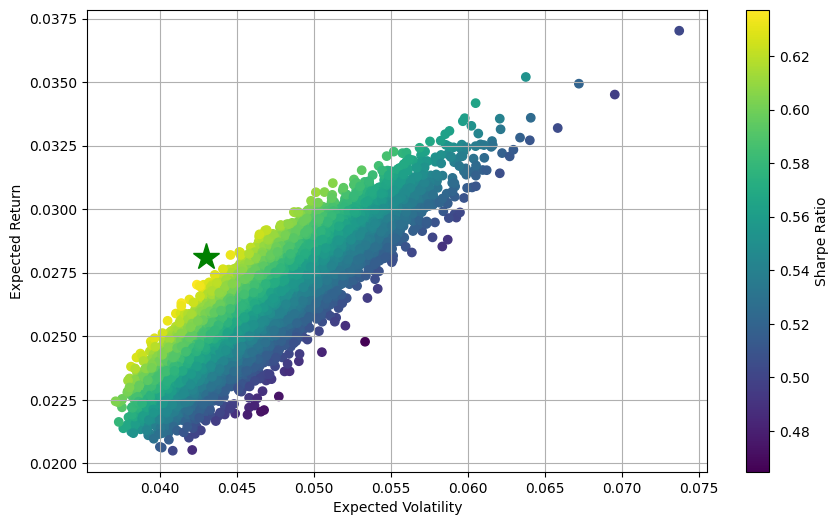

In [31]:
if __name__ == '__main__':
    pweights, means, risks = generate_portfolios(strategy1_series)
    optimum = optimize_portfolio(pweights[0], strategy1_series)
    print_optimal_portfolio(optimum, strategy1_series)
    show_optimal_portfolio(optimum, strategy1_series, means, risks)

### 3.2 Optimize Strategy 2

Optimal portfolio:  [0.129 0.268 0.008 0.116 0.    0.072 0.    0.208 0.025 0.174]
Expected return, volatility and Sharpe ratio:  [0.02768277 0.042169   0.6114923 ]


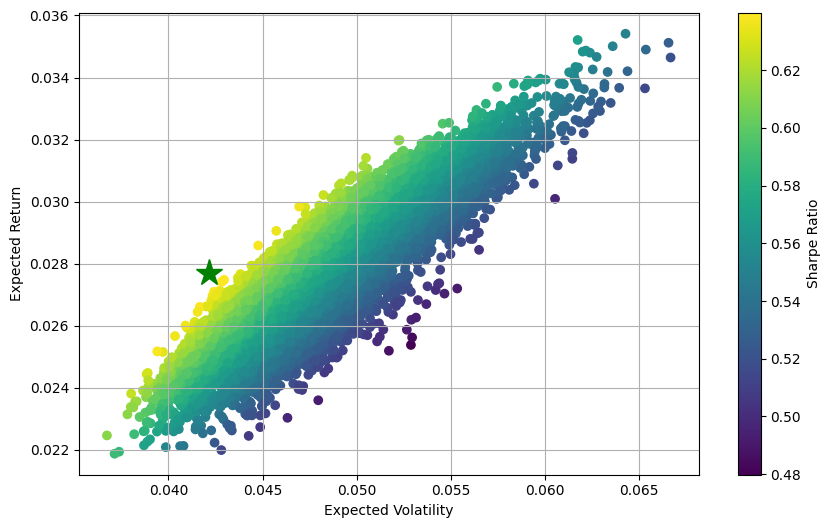

In [32]:
if __name__ == '__main__':
    pweights, means, risks = generate_portfolios(strategy2_series)
    optimum = optimize_portfolio(pweights[0], strategy2_series)
    print_optimal_portfolio(optimum, strategy2_series)
    show_optimal_portfolio(optimum, strategy2_series, means, risks)

### 3.3 Optimize Strategy 3

Optimal portfolio:  [0.129 0.116 0.008 0.268 0.    0.    0.071 0.208 0.025 0.175]
Expected return, volatility and Sharpe ratio:  [0.02768626 0.0421747  0.61149221]


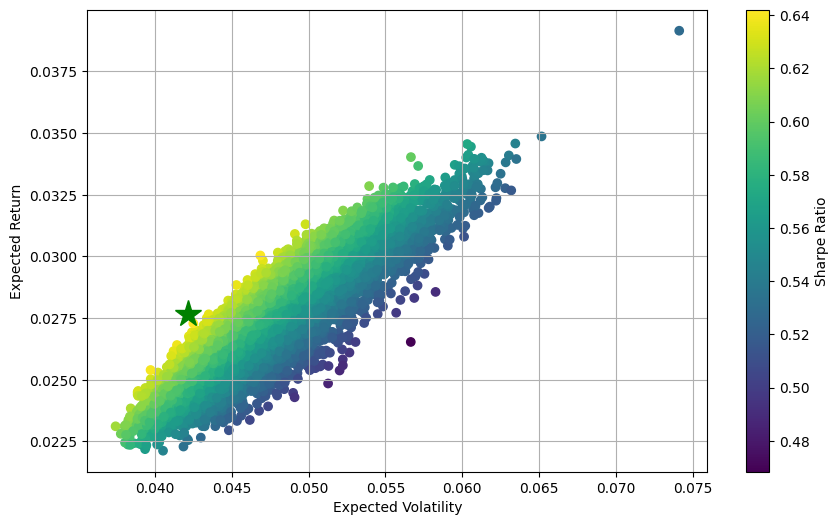

In [33]:
if __name__ == '__main__':
    pweights, means, risks = generate_portfolios(strategy3_series)
    optimum = optimize_portfolio(pweights[0], strategy3_series)
    print_optimal_portfolio(optimum, strategy3_series)
    show_optimal_portfolio(optimum, strategy3_series, means, risks)

### 3.4 Backtesting Strategy 4
- Backtesting using rebalance portfolio monthly

In [34]:
strategy4_ret_df = pflio_monthly(returns_series, m=10)
mon = strategy4_ret_df["mon_ret"].iloc[1:]
strategy4_cum = (1 + mon).cumprod()

cagr_monthly = strategy4_cum.iloc[-1].item() ** (12 / len(mon)) - 1
vol_monthly = mon.std(ddof=1) * np.sqrt(12)
rf_monthly = (1 + rf_annual) ** (1/12) - 1
sharpe_monthly = ((mon.mean() - rf_monthly) / mon.std(ddof=1)) * np.sqrt(12)

print("\n")
print(f"CAGR: {cagr_monthly:.4%}")
print(f"Volatility: {vol_monthly:.4%}")
print(f"Sharpe Ratio: {sharpe_monthly:.2f}")

['NEM', 'NFLX', 'LULU', 'EA', 'FANG', 'BIIB', 'AMZN', 'O', 'SWKS', 'HOLX']
['FSLR', 'TKO', 'MLM', 'FCX', 'ON', 'EPAM', 'MOH', 'AVGO', 'CRM', 'BKNG']
['NXPI', 'CNC', 'COO', 'CBRE', 'SWKS', 'RMD', 'STLD', 'COR', 'BLDR', 'ROL']
['BLDR', 'CZR', 'NFLX', 'AXON', 'FCX', 'NEM', 'VTRS', 'TSLA', 'MSFT', 'LYB']
['HUM', 'AVGO', 'MOH', 'CNC', 'ZBRA', 'SWKS', 'NXPI', 'SMCI', 'TER', 'CZR']
['ANET', 'TKO', 'CI', 'ROL', 'WMB', 'CAG', 'DXCM', 'HCA', 'UHS', 'PODD']
['AMZN', 'CMG', 'NFLX', 'GOOGL', 'GOOG', 'TKO', 'BLDR', 'FTNT', 'AMGN', 'VRSN']
['PAYC', 'BBY', 'NVDA', 'CZR', 'INCY', 'DXCM', 'CDW', 'SYY', 'FSLR', 'MSI']
['TAP', 'TPL', 'JBL', 'IRM', 'NI', 'NKE', 'NVDA', 'WEC', 'EIX', 'TYL']
['TRMB', 'KLAC', 'FSLR', 'WYNN', 'LVS', 'LDOS', 'MGM', 'ADSK', 'URI', 'AMD']
['PODD', 'NSC', 'NXPI', 'CRL', 'PANW', 'VTRS', 'DLTR', 'ADSK', 'PAYC', 'ANET']
['ENPH', 'AMD', 'FSLR', 'CNC', 'CZR', 'DRI', 'AVGO', 'KR', 'ULTA', 'WYNN']
['SMCI', 'EQT', 'LULU', 'CTRA', 'TPR', 'FANG', 'KMI', 'HAS', 'NEM', 'ATO']
['FCX', 'NEM', '

### 3.5 Backtesting Strategy 5
- Backtesting using rebalance portfolio quarterly
- We measure the Sharpe ratio using monthly portfolio returns, even if the portfolio is rebalanced quarterly.
    - This is because the portfolio still generates returns every month; using monthly data gives a more detailed and statistically stable measure of risk and return.
    - The rebalancing frequency only determines when we change the holdings, not how often we observe performance.
    - If we measured Sharpe on a quarterly basis, we would have fewer data points—more aligned with the decision cycle, but less precise statistically.

In [28]:
strategy5_ret_df = pflio_quarterly(returns_series, m=10)
_mon = strategy5_ret_df["mon_ret"].iloc[1:]
strategy5_cum = (1 + _mon).cumprod()

cagr_quarterly = strategy5_cum.iloc[-1].item() ** (12 / len(_mon)) - 1
vol_quarterly = _mon.std(ddof=1) * np.sqrt(12)
rf_monthly = (1 + rf_annual) ** (1/12) - 1
sharpe_quarterly = ((_mon.mean() - rf_monthly) / _mon.std(ddof=1)) * np.sqrt(12)

print("\n")
print(f"CAGR: {cagr_quarterly:.4%}")
print(f"Volatility: {vol_quarterly:.4%}")
print(f"Sharpe Ratio: {sharpe_quarterly:.2f}")

Month 2: Portfolio = ['CNC', 'SWKS', 'FSLR', 'BSX', 'NXPI', 'MSCI', 'VLO', 'RMD', 'FANG', 'VMC']
Month 5: Portfolio = ['BLDR', 'NFLX', 'CZR', 'TSLA', 'AXON', 'DXCM', 'CI', 'ZBRA', 'TMUS', 'UHS']
Month 8: Portfolio = ['NVDA', 'MSI', 'TAP', 'CDW', 'EXR', 'CMG', 'AIZ', 'GOOGL', 'AMZN', 'CBOE']
Month 11: Portfolio = ['AMD', 'FSLR', 'PODD', 'KLAC', 'ADSK', 'LDOS', 'VTRS', 'NVDA', 'AMZN', 'WYNN']
Month 14: Portfolio = ['FCX', 'NEM', 'SMCI', 'WYNN', 'EXC', 'EQT', 'LULU', 'CTRA', 'IRM', 'DECK']
Month 17: Portfolio = ['AMD', 'OKE', 'NEM', 'TRGP', 'WMB', 'MTCH', 'CZR', 'DVN', 'NVDA', 'MU']
Month 20: Portfolio = ['STX', 'DHR', 'NTAP', 'NVDA', 'WMB', 'TPL', 'EBAY', 'ON', 'ZBRA', 'PODD']
Month 23: Portfolio = ['AMD', 'NVDA', 'KEY', 'GS', 'RF', 'CFG', 'STLD', 'BAC', 'UAL', 'MTB']
Month 26: Portfolio = ['NRG', 'VRTX', 'DXCM', 'ANET', 'BLDR', 'ENPH', 'INCY', 'WYNN', 'MU', 'IDXX']
Month 29: Portfolio = ['MOH', 'FSLR', 'NVDA', 'ALGN', 'TSLA', 'CSGP', 'REGN', 'EW', 'TTWO', 'MTD']
Month 32: Portfolio = ['

### 3.6 Backtesting Strategy 6
- Backtesting using rebalance portfolio annually
- We measure the Sharpe ratio using monthly portfolio returns, even if the portfolio is rebalanced annually.
    - This is because the portfolio still generates returns every month; using monthly data gives a more detailed and statistically stable measure of risk and return.
    - The rebalancing frequency only determines when we change the holdings, not how often we observe performance.
    - If we measured Sharpe on a quarterly basis, we would have fewer data points—more aligned with the decision cycle, but less precise statistically.

In [30]:
strategy6_ret_df = pflio_annually(returns_series, m=10)
_mon = strategy6_ret_df["mon_ret"].iloc[1:]
strategy6_cum = (1 + _mon).cumprod()

cagr_annually = strategy6_cum.iloc[-1].item() ** (12 / len(_mon)) - 1
vol_annually = _mon.std(ddof=1) * np.sqrt(12)
rf_monthly = (1 + rf_annual) ** (1/12) - 1
sharpe_annually = ((_mon.mean() - rf_monthly) / _mon.std(ddof=1)) * np.sqrt(12)

print("\n")
print(f"CAGR: {cagr_annually:.4%}")
print(f"Volatility: {vol_annually:.4%}")
print(f"Sharpe Ratio: {sharpe_annually:.2f}")

Month 11: Portfolio = ['CZR', 'NFLX', 'AMZN', 'NVDA', 'EPAM', 'BLDR', 'GPN', 'TYL', 'MKTX', 'EXR']
Month 23: Portfolio = ['AMD', 'NVDA', 'OKE', 'TRGP', 'TPL', 'STLD', 'FCX', 'NEM', 'NDSN', 'AMAT']
Month 35: Portfolio = ['ANET', 'ENPH', 'NRG', 'ALGN', 'TTWO', 'FSLR', 'NVR', 'VRTX', 'BLDR', 'WYNN']
Month 47: Portfolio = ['TKO', 'DXCM', 'ENPH', 'AMD', 'KDP', 'AXON', 'FTNT', 'DECK', 'WDAY', 'LULU']
Month 59: Portfolio = ['ENPH', 'AMD', 'BLDR', 'LRCX', 'TER', 'PAYC', 'PODD', 'APO', 'KLAC', 'GNRC']
Month 71: Portfolio = ['TSLA', 'ENPH', 'GNRC', 'NVDA', 'MPWR', 'ALB', 'AMD', 'FCX', 'CDNS', 'NOW']
Month 83: Portfolio = ['DVN', 'FTNT', 'F', 'FANG', 'NVDA', 'NUE', 'BLDR', 'IT', 'ON', 'BX']
Month 95: Portfolio = ['OXY', 'TPL', 'XOM', 'SMCI', 'MPC', 'SLB', 'APA', 'VLO', 'HAL', 'FSLR']
Month 107: Portfolio = ['SMCI', 'NVDA', 'META', 'RCL', 'BLDR', 'CCL', 'PHM', 'AMD', 'PANW', 'AVGO']
Month 119: Portfolio = ['NVDA', 'UAL', 'AXON', 'TPL', 'AVGO', 'TRGP', 'ANET', 'WSM', 'NFLX', 'DECK']


CAGR: 30.8573

## 4. Compare Strategy with KPI

### 4.1 Compare CAGR, Volatility, Sharpe-Ratio
- As result, return of Strategy 1, 2, 3 using "Maximize Sharpe-Raito" is bad because
    - Keep the stocks at the same all base on Sharpe-Ratio, Beta, Z-score
    - No changing in anything even there are shocks or crisis.

- As result, return of Strategy 4, 5, 6 using "Rebalancing Portfolio" is great because
    - Keep changing stocks all the time base on highest return.
    - This help portfolio always tune.

In [35]:
print("Strategy1")
print_optimal_portfolio(optimum, strategy1_series)

print("\n Strategy2")
print_optimal_portfolio(optimum, strategy2_series)

print("\n Strategy3")
print_optimal_portfolio(optimum, strategy3_series)

print("\n Strategy4")
print(f"CAGR: {cagr_monthly:.4%}")
print(f"Volatility: {vol_monthly:.4%}")
print(f"Sharpe Ratio: {sharpe_monthly:.2f}")

print("\n Strategy5")
print(f"CAGR: {cagr_quarterly:.4%}")
print(f"Volatility: {vol_quarterly:.4%}")
print(f"Sharpe Ratio: {sharpe_quarterly:.2f}")

print("\n Strategy6")
print(f"CAGR: {cagr_annually:.4%}")
print(f"Volatility: {vol_annually:.4%}")
print(f"Sharpe Ratio: {sharpe_annually:.2f}")

Strategy1
Optimal portfolio:  [0.129 0.116 0.008 0.268 0.    0.    0.071 0.208 0.025 0.175]
Expected return, volatility and Sharpe ratio:  [0.02728947 0.04757412 0.53375055]

 Strategy2
Optimal portfolio:  [0.129 0.116 0.008 0.268 0.    0.    0.071 0.208 0.025 0.175]
Expected return, volatility and Sharpe ratio:  [0.02972278 0.04922233 0.56531297]

 Strategy3
Optimal portfolio:  [0.129 0.116 0.008 0.268 0.    0.    0.071 0.208 0.025 0.175]
Expected return, volatility and Sharpe ratio:  [0.02768626 0.0421747  0.61149221]

 Strategy4
CAGR: 24.3304%
Volatility: 22.2088%
Sharpe Ratio: 1.00

 Strategy5
CAGR: 23.4605%
Volatility: 23.4620%
Sharpe Ratio: 0.93

 Strategy6
CAGR: 30.8573%
Volatility: 25.7876%
Sharpe Ratio: 1.09


### 4.2 VaR + Monte-Carlo & More KPI Code for Strategy 4, 5, 6

In [36]:
def evaluate_strategy_row(strategy_name, cumulative, mon_ret, rf_annual=0.023, confidence_level=0.95):
    n = len(mon_ret)
    cagr = cumulative.iloc[-1].item() ** (12 / n) - 1
    vol = mon_ret.std() * np.sqrt(12)
    sharpe = (cagr - rf_annual) / vol
    max_dd = (cumulative / cumulative.cummax() - 1).min()
    
    downside_std = mon_ret[mon_ret < 0].std() * np.sqrt(12)
    sortino = (cagr - rf_annual) / downside_std if downside_std != 0 else np.nan
    calmar = cagr / abs(max_dd) if max_dd != 0 else np.nan

    mu = mon_ret.mean()
    sigma = mon_ret.std()
    simulated_returns = np.random.normal(mu, sigma, 10000)
    var_95 = np.percentile(simulated_returns, (1 - confidence_level) * 100)

    return {
        "Strategy": strategy_name,
        "CAGR": f"{cagr:.2%}",
        "Volatility": f"{vol:.2%}",
        "Max Drawdown": f"{max_dd:.2%}",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Sortino Ratio": f"{sortino:.2f}",
        "Calmar Ratio": f"{calmar:.2f}",
        "95% Monte Carlo VaR": f"{var_95:.2%}"
    }

### 4.3 KPI for Strategy 4, 5, 6

In [40]:
strategy_results = []

strategy_results.append(evaluate_strategy_row("Strategy 4", strategy4_cum, strategy4_ret_df["mon_ret"]))
strategy_results.append(evaluate_strategy_row("Strategy 5", strategy5_cum, strategy5_ret_df["mon_ret"]))
strategy_results.append(evaluate_strategy_row("Strategy 6", strategy6_cum, strategy6_ret_df["mon_ret"]))

In [41]:
df_strategy_results = pd.DataFrame(strategy_results)
display(df_strategy_results)

,Strategy,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,95% Monte Carlo VaR
0,Strategy 4,24.11%,22.13%,-25.53%,0.99,1.34,0.94,-8.33%
1,Strategy 5,23.24%,23.37%,-30.95%,0.90,1.28,0.75,-9.15%
2,Strategy 6,30.56%,25.69%,-26.23%,1.10,1.70,1.17,-9.92%


## 5. Conclusion
1. Optimize Strategy
    - Strategy 1–3: Use Sharpe Ratio, CAPM, Z-score to filter stocks then Optimize Portfolio by Maximum Sharpe-Ratio
    - Result: Achieved lower risk but relatively modest returns (CAGR ≈ 2–3%).
    - The low return is mainly because the portfolio was constructed only once at the start and held for 10 years without rebalancing.

2. Backtesting Strategy
    - Strategy 4: Monthly Rebalancing, CAGR ~ 24.11% per year.
    - Strategy 5: Quarterly Rebalancing, CAGR ~ 23.24% per year.
    - Strategy 6: Annually Rebalancing, CAGR ~ 30.56% per year.
    - These strategies delivered higher returns but also higher risk, with maximum drawdowns exceeding 25%.
    - Despite the risk, the strategies generated long-term returns above 20%, which appear somewhat unrealistic in practice.
    - This exceptional performance may reflect structural market shifts, such as AI-driven disruption and strong technology-sector growth.
    - Which particularly benefited the rebalancing strategies during the sample period.

3. Conclusion
    - This strategy focuses on selecting only the highest-returning stocks, naturally is tech stocks, which makes the portfolio more volatile and concentrated. 
    - Under current market conditions — such as the AI-driven boom, potential tech-sector overvaluation, and other bubble-like dynamics.
    - There is a heightened risk that the portfolio could suffer sharp drawdowns or even collapse if market sentiment reverses.